##### Author:
    Diana Y. Lee, Luque Lab, SDSU
    dlee@sdsu.edu

##### Purpose:
    Times the Similarity algorithms
    Implements hypothetical large datasets
    Compares the Similarity timing with (imported) Random Forest timing 
    Creates the base illustrations for Figure 6 and related SI of the paper in preparation titled, [TBD]

##### Requires: 
    phage_functions.ipynb 
    data\PHAGE_TABLE1.xlsx : phage data with indexes, genome size, and translations
    data\MCPdbblastpe001.csv : Similarity table from blastp (e value = 0.001)
    #RF timing data from Fig 5 ipynb (hard-coded in)
    
##### Database file: 
    item6_update.db
    
##### Creates:
    FigS6_sim_v_RF_time_train.svg \ .png
    FigS6_sim_v_RF_time_predict.svg \ .png
    FigS6_sim_v_RF_time_all.svg \ .png
    FigS6_sim_v_RF_time_train_to_1M \ .png
    FigS6_sim_v_RF_time_predict_to_1M.svg \ .png


In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(8)
import math
import copy
import csv
import time
import os 
import random
import statistics
import seaborn as sn

In [2]:
# ML imports
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [3]:
from ipynb.fs.full.phage_functions import tNearest
from ipynb.fs.full.phage_functions import tNearestValid
from ipynb.fs.full.phage_functions import tModel
from ipynb.fs.full.phage_functions import tNum
from ipynb.fs.full.phage_functions import tList

In [4]:
#create a list of possible, valid T-numbers, as well as separate t-number lists for T_h and T_t 
tps2, tps, tps_t, tps_h = tList(7)

In [5]:
# error margin
errMar = 0.09

In [51]:
# function to clean up an NCBI alignment text file

def newAlign(sim_table):
    
    # rename the columns
    sim_table.columns = ['query from', 'query to', 'percent identity', 'alignment length','mismatches', 'gap opens', 'query start', 'query end', 's start', 's end', 'evalue', 'bit score', 'percent positives']
    # create a boolean for each line that is true if it starts with 'ph'
    is_ph =  sim_table['query from']>'ph'
    # create a new table based on that boolean filter
    sim_ph = sim_table[is_ph]
    # create a boolean for each line that compares to itself
    is_nxn =  sim_table['query from']!=sim_table['query to']
    # apply the second filter
    sim_ph = sim_ph[is_nxn]
    # strip the 'ph' from the table
    sim_ph["query from"] = sim_ph["query from"].map(lambda x: x.lstrip('ph'))
    sim_ph["query to"] = sim_ph["query to"].map(lambda x: x.lstrip('ph'))

#    print(sim_ph.shape)
    return sim_ph
    #print(sim_ph.head())

In [7]:
# function to create a matrix of pairwise percent similarity (nxn)

def pairwiseMatrix(sim_table,nn):
    sLines = len(sim_table)
    tProx = np.zeros((nn,nn))

    for i in range(sLines):
        jVal = int(np.asarray(sim_table["query from"])[i])
        kVal = int(np.asarray(sim_table["query to"])[i])
        
        simVal = round(np.asarray(sim_table["percent identity"])[i],3)

        if (simVal>tProx[jVal][kVal]):
            tProx[jVal][kVal] = round(np.asarray(sim_table["percent identity"])[i],3)
        if (simVal>tProx[kVal][jVal]):
            tProx[kVal][jVal] = round(np.asarray(sim_table["percent identity"])[i],3)

# now do it again for to-from, since there isn't symmetry in the results
    for i in range(sLines):
        jVal = int(np.asarray(sim_table["query to"])[i])
        kVal = int(np.asarray(sim_table["query from"])[i])
        
        simVal = round(np.asarray(sim_table["percent identity"])[i],3)

        if (simVal>tProx[jVal][kVal]):
            tProx[jVal][kVal] = round(np.asarray(sim_table["percent identity"])[i],3)
        if (simVal>tProx[kVal][jVal]):
            tProx[kVal][jVal] = round(np.asarray(sim_table["percent identity"])[i],3)
           
            
    return tProx

In [8]:
# function to separate the similarity table into 20% increments

def Percentile20(tProx, Tij, n2):

    allResults01 = []
    Series01 = []
    Series02 = []
    Series03 = []
    Series04 = []
    Series05 = []

    for i in range(n2):
        for j in range(n2):
            if i < j:
                allResults01.append(i);
                allResults01.append(j);
                allResults01.append(tProx[i][j]);
                allResults01.append(Tij[i][j]);
                if(tProx[i][j] <= 20.0):
                    Series01.append(Tij[i][j]);
                if(tProx[i][j] > 20.0 and tProx[i][j]<=40.0):
                    Series02.append(Tij[i][j]);
                if(tProx[i][j] > 40.0 and tProx[i][j]<=60.0):
                    Series03.append(Tij[i][j]);
                if(tProx[i][j] > 60.0 and tProx[i][j]<=80.0):
                    Series04.append(Tij[i][j]);
                if(tProx[i][j] > 80.0 and tProx[i][j]<=100.0):
                    Series05.append(Tij[i][j]);


    allResults01 = np.asarray(allResults01);
    Series01 = np.asarray(Series01);
    Series02 = np.asarray(Series02);
    Series03 = np.asarray(Series03);
    Series04 = np.asarray(Series04);
    Series05 = np.asarray(Series05);

    plotData = [Series01,Series02,Series03,Series04,Series05]

    from scipy.special import comb
    nn = (int)(comb(n2,2));

    allResults = np.reshape(np.ravel(allResults01), (nn, 4));
    allResults = np.asarray(allResults);
    
    return allResults, plotData

In [9]:
# import phage data
phageData = pd.read_excel("data\PHAGE_TABLE1.xlsx")
n = len(phageData)

# isolate the genome size
genomebps = np.asarray(phageData["COMPLETE_GENOME_BP"])

# create T number table for raw T number
tRaw = np.zeros((n))
for i in range(n):
    tRaw[i] = tNum(genomebps[i]/1000,0)

# create T number table for nearest valid T number
tNear = np.zeros((n))
for i in range(n):
    tNear[i] = tNum(genomebps[i]/1000,1)

# create T number table for nearest valid T number within error margin
tNearV = np.zeros((n))
for i in range(n):
    tNearV[i] = tNum(genomebps[i]/1000,2,errMar)
    
# isolate the MCP translation data
translation=np.asarray(phageData["TRANSLATION"])

# import blastp hit table with an e value = 0.001
sim_e001 = pd.read_csv("data\MCPdbblastpe001.csv")



In [24]:
# timing for MCP Genome database (n=669)
n_iter = 10
base_time = []

for m in range(n_iter):
    start1 = time.perf_counter()

    # clean up the tables
    sim_ph_e001 = newAlign(sim_e001)

    # create pairwise similarity matrices
    tProx_e001 = pairwiseMatrix(sim_ph_e001,n)

    # create a matrix of pairwise *average relative* difference in T-number (nxn)
    Tij_dist2 = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Tij_dist2[i][j]=0.5*((abs(tRaw[i]-tRaw[j])/tRaw[i])+(abs(tRaw[i]-tRaw[j])/tRaw[j]));

    ph_num = np.arange(0,n)
    Tij_distDF2 = pd.DataFrame(Tij_dist2, columns=[ph_num])
    tProx_e001DF = pd.DataFrame(tProx_e001, columns=[ph_num])

    # break up both table into 20 percentile increments
    all_e001, plotdata_e001 = Percentile20(np.asarray(tProx_e001DF), np.asarray(Tij_distDF2), n)

    # create a truncated t list with zero at the end
    tps3 = tps[:21]
    tps3 = np.insert(tps3,21,0)

    # create an x-label list for plotting
    tps4 = []
    tps4.append(" ")
    for i in tps[:21]:
        tps4.append(i)
    tps4.append('No T')
    tps4 = np.asarray(tps4)

    # create an array of similarity percentages by T-number (e-val=0.001)
    allT1 = []
    allLocs = []
    tempT = []
    allCount = []
    tempCount = 0


    for j in tps3:
        tempT = []
        tempCount = 0
        for i in range(669):
            if j == tNearV[i]:
                tempCount = tempCount+1
                tempT.append(i)
        allLocs.append(tempT)
        allCount.append(tempCount)

    for i in range(len(tps3)):
        tempT = []
        if len(allLocs[i])==0:
            tempT.append(0)
        else:
            for j in allLocs[i]:
                for k in allLocs[i]:
                    if j<k:
                        tempT.append(tProx_e001[j][k])
        allT1.append(tempT)

    finish1 = time.perf_counter()
    base_time.append(finish1-start1)
print("average time (s) over", n_iter, " iterations = ",np.mean(base_time))

<ipython-input-6-d1701fe3f07f>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sim_ph = sim_ph[is_nxn]


(22035, 13)
(22035, 13)
(22035, 13)
(22035, 13)
(22035, 13)
(22035, 13)
(22035, 13)
(22035, 13)
(22035, 13)
(22035, 13)
average time (s) over 10  iterations =  3.303016080000009


In [62]:
# timing for hypothetical databases through 100K in size(n=669)
n_iter = 15
base_time = []
mult_iter = 15
n_temp = 669

import warnings
warnings.filterwarnings("ignore")

for m in range(n_iter):
    start1 = time.perf_counter()

    for q in range(m*10+1):
        
        # clean up the tables
        sim_ph_e001 = newAlign(sim_e001)

        # create pairwise similarity matrices
        tProx_e001 = pairwiseMatrix(sim_ph_e001,n)

        # create a matrix of pairwise *average relative* difference in T-number (nxn)
        Tij_dist2 = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                Tij_dist2[i][j]=0.5*((abs(tRaw[i]-tRaw[j])/tRaw[i])+(abs(tRaw[i]-tRaw[j])/tRaw[j]));
    finish1 = time.perf_counter()
    
    start2 = time.perf_counter()
    
    for q in range(m*10+1):
        # set train and test sizes
        n80 = round(n_temp*.80)
        n20 = n_temp-n80

        stats_acc_all = np.zeros((10,3))

        # create a random shuffle of the phage data
        shuffle_index = np.random.permutation(n)
        # create a list of the phages by number
        phagelist = np.arange(0,n_temp)


        # split into an 80/20 training set
        p80 = phagelist[shuffle_index][:n80]
        p20 = phagelist[shuffle_index][n80:]

        # for each line item in the test set, find the item in the train set that is most similar
        # create a placeholder for the list (from phage -- to phage -- sim % -- from T -- to T -- check)
        predict_t20=np.zeros((n20,6))

        # for each item in the test set
        for i in range(len(p20)):
            # add the from phage to the new table
            predict_t20[i][0]=p20[i]
            # fill the to phage columm so there's no confusion between no prediction and phage #0
            predict_t20[i][1]=-1
            # for each column (to phage) in tprox
            for j in range(n):
                # if the to phage is in the training set
                if (j in p80):
                    # and if the similarity percentage is larger than what was there before (all start at zero) 
                    # AND larger than the threshold
                    if ((tProx_e001[p20[i]][j] > predict_t20[i][2]) and (tProx_e001[p20[i]][j] > m*10)):
                        #then update the to phage and similarity percentage in our prediction table
                        predict_t20[i][2]=tProx_e001[p20[i]][j]
                        predict_t20[i][1]=j
            # retrieve the T-number prediction for the from phage
            predict_t20[i][3]=tNearV[int(predict_t20[i][0])]
            # retrieve the T-number prediction for the most similar phage found in the train set
            predict_t20[i][4]=tNearV[int(predict_t20[i][1])]
    finish2 = time.perf_counter()

    base_time.append(n_temp)
    n_temp=n_temp+6690
    base_time.append(finish1-start1)
    base_time.append(finish2-start2)
    #print(base_time)
base_time = np.asarray(np.reshape(np.ravel(base_time), (n_iter, 3)))
print(base_time)

[6690, 2.6777645999973174, 6.960000246181153e-05]
[6690, 2.6777645999973174, 6.960000246181153e-05, 13380, 29.32073759999912, 7.389999882434495e-05]
[6690, 2.6777645999973174, 6.960000246181153e-05, 13380, 29.32073759999912, 7.389999882434495e-05, 20070, 56.67253290000008, 7.800000093993731e-05]
[6690, 2.6777645999973174, 6.960000246181153e-05, 13380, 29.32073759999912, 7.389999882434495e-05, 20070, 56.67253290000008, 7.800000093993731e-05, 26760, 83.98827629999869, 8.300000263261609e-05]
[6690, 2.6777645999973174, 6.960000246181153e-05, 13380, 29.32073759999912, 7.389999882434495e-05, 20070, 56.67253290000008, 7.800000093993731e-05, 26760, 83.98827629999869, 8.300000263261609e-05, 33450, 111.11056390000158, 8.209999941755086e-05]
[6690, 2.6777645999973174, 6.960000246181153e-05, 13380, 29.32073759999912, 7.389999882434495e-05, 20070, 56.67253290000008, 7.800000093993731e-05, 26760, 83.98827629999869, 8.300000263261609e-05, 33450, 111.11056390000158, 8.209999941755086e-05, 40140, 137.4

In [9]:
# timing for hypothetical databases through 100K in size(n=669 through 100350)

stat_iter = 100
base_time = []
base_time_train = []
base_time_predict = []
n_iter = 15
mult_iter = 15
n_temp = 669

import warnings
warnings.filterwarnings("ignore")

for gg in range(stat_iter):

    for m in range(n_iter):
        start1 = time.perf_counter()

        for q in range(m):

            # clean up the tables
            sim_ph_e001 = newAlign(sim_e001)

            # create pairwise similarity matrices
            tProx_e001 = pairwiseMatrix(sim_ph_e001,n)

            # create a matrix of pairwise *average relative* difference in T-number (nxn)
            Tij_dist2 = np.zeros((n,n))
            for i in range(n):
                for j in range(n):
                    Tij_dist2[i][j]=0.5*((abs(tRaw[i]-tRaw[j])/tRaw[i])+(abs(tRaw[i]-tRaw[j])/tRaw[j]));
        finish1 = time.perf_counter()

        base_time.append(n_temp)
        n_temp=n_temp+669
        base_time_train.append(finish1-start1)
        
    #print(base_time)
    n_temp=669
    if (gg%10==0):
        print("loop ",gg)
    
print(base_time)
print(base_time_train)
#print(base_time_predict)

loop  0
loop  10
loop  20
loop  30
loop  40
loop  50
loop  60
loop  70
loop  80
loop  90
[669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338, 2007, 2676, 3345, 4014, 4683, 5352, 6021, 6690, 7359, 8028, 8697, 9366, 10035, 669, 1338,

In [174]:
# timing for hypothetical databases through 100K in size(n=669 through 100350)
# replaces original predict due to errors in original code

stat_iter = 100
base_time_predict = []
n_iter = 15
mult_iter = 15
n_temp = 669
n20 = 50
p20 = phagelist[:n20]

for gg in range(stat_iter):

    start2 = time.perf_counter()

    for q in range(n_iter):

        p80 = phagelist[n20:n_temp]
        # create a placeholder for the list (from phage -- to phage -- sim % -- from T -- to T -- check)
        predict_t20=np.zeros((n20,6))

        # for each line item in the test set, find the item in the train set that is most similar
        # for each item in the test set
        for i in range(n20):
            # add the from phage to the new table
            predict_t20[i][0]=p20[i]
            # fill the to phage columm so there's no confusion between no prediction and phage #0
            predict_t20[i][1]=-1
            # for each column (to phage) in tprox
            for j in range(n):
                # if the to phage is in the training set
                if (j in p80):
                    # and if the similarity percentage is larger than what was there before (all start at zero) 
                    # AND larger than the threshold
                    if ((tProx_e001[p20[i]][j] > predict_t20[i][2]) and (tProx_e001[p20[i]][j] > m*10)):
                        #then update the to phage and similarity percentage in our prediction table
                        predict_t20[i][2]=tProx_e001[p20[i]][j]
                        predict_t20[i][1]=j
            # retrieve the T-number prediction for the from phage
            predict_t20[i][3]=tNearV[int(predict_t20[i][0])]
            # retrieve the T-number prediction for the most similar phage found in the train set
            predict_t20[i][4]=tNearV[int(predict_t20[i][1])]
        finish2 = time.perf_counter()

        n_temp=n_temp+669
        base_time_predict.append(finish2-start2)
        
    #print(base_time)
    n_temp=669
    if (gg%10==0):
        print("loop ",gg)
    
print(base_time_predict)

loop  0
loop  10
loop  20
loop  30
loop  40
loop  50
loop  60
loop  70
loop  80
loop  90
[0.0029961999971419573, 0.0057809999998426065, 0.008566199991037138, 0.011665199999697506, 0.015024299995275214, 0.021318600003723986, 0.02619859999686014, 0.030185900002834387, 0.03463539999211207, 0.038504500000271946, 0.042937399994116277, 0.04718249999859836, 0.05161339999176562, 0.05662849999498576, 0.06143329999758862, 0.002182700001867488, 0.0043594000017037615, 0.0067337999935261905, 0.00940519999130629, 0.012387499999022111, 0.01543390000006184, 0.01881870000215713, 0.022549299988895655, 0.02645029999257531, 0.030307799999718554, 0.03435249999165535, 0.03858589999435935, 0.04309609999472741, 0.04792260000249371, 0.052727199989021756, 0.0018629999976838008, 0.004114199997275136, 0.006458499992731959, 0.008971999995992519, 0.011836199992103502, 0.014794100003200583, 0.018053499996312894, 0.02170029999979306, 0.025333099998533726, 0.029037500004051253, 0.032927699998253956, 0.0370775999908801

In [175]:
print(len(base_time))
print(len(base_time_train))
print(len(base_time_predict))

1500
1500
1500


In [224]:
bt_train = pd.DataFrame(np.reshape(np.ravel(base_time_train), (-1,15)))
bt_predict = pd.DataFrame(np.reshape(np.ravel(base_time_predict), (-1,15)))

bt_train_avg = []
bt_predict_avg = []

for i in range(15):
    bt_train_avg.append(np.mean(bt_train[i]))
    bt_predict_avg.append(np.mean(bt_predict[i]))
    
bt_train_avg = np.asarray(bt_train_avg)
bt_predict_avg = np.asarray(bt_predict_avg)
bt_predict_avg = bt_predict_avg/50
bt_n = np.asarray(base_time[:15])


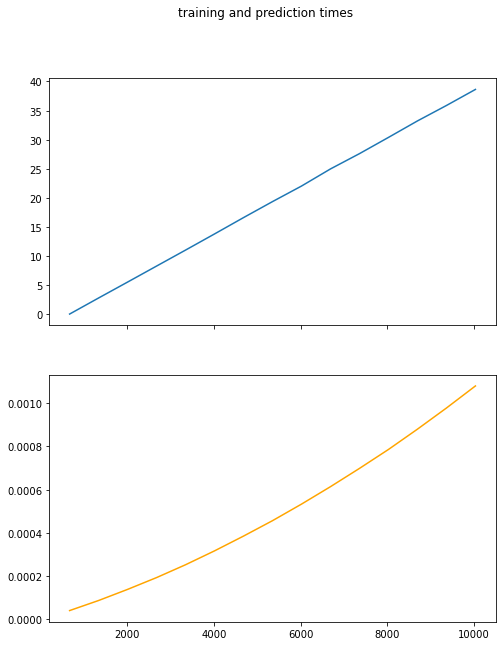

In [233]:
fig, (ax1, ax2) = plt.subplots(2,sharex=True,figsize=(8, 10))
fig.suptitle('training and prediction times')
ax1.plot(bt_n,bt_train_avg)
ax2.plot(bt_n,bt_predict_avg, color='orange')

In [82]:
# regression imports
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import sklearn.metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, explained_variance_score
from scipy.optimize import least_squares

In [197]:
bt_n = bt_n.reshape(-1, 1)
bt_train_avg = bt_train_avg.reshape(-1, 1)
bt_predict_avg = bt_predict_avg.reshape(-1, 1)

In [112]:
# create linear regression model for training times
modelT1 = LinearRegression()
modelT1.fit(bt_n,bt_train_avg)
y_predT1 = modelT1.predict(bt_n)
intT1 = modelT1.intercept_[0]
slopeT1 = modelT1.coef_[0][0]
print('model slope: %.6f' % slopeT1)
print('model intercept: %.6f' % intT1)

# create linspace for x and y
xlinT1 = np.linspace(min(bt_n)-0.1,max(bt_n)+0.1, 100)
ylinT1 = slopeT1*xlinT1+intT1

# Predicted values based on regression
print("Mean squared error: %.4f" % mean_squared_error(bt_train_avg, y_predT1))
print('R-squared: %.4f' % r2_score(bt_train_avg, y_predT1))
print('explained_variance_score: %.4f' % explained_variance_score(bt_train_avg, y_predT1))

from scipy.stats import t

# CI and degrees of freedom
p = 0.95
df = n-2

# use t.ppdf to retrieve probability
tvalue = t.ppf(p, df)

print('Critical t for', p, 'CI with', df, 'degrees of freedom: %.4f' % tvalue)

# statistics we need to calculate errors
xDmean = np.mean(bt_n)
xDmse = mean_squared_error(bt_train_avg, y_predT1)
# calculate sum of (x-xbar)^2
x_su = 0
for i in bt_n:
    x_su = x_su + (i-xDmean)**2;

# Calculate error on the slope
# https://newonlinecourses.science.psu.edu/stat501/node/261/
xDslopeErr = tvalue*np.sqrt(xDmse)/np.sqrt(x_su)[0]
print('Error of the slope estimate: %.4f' % xDslopeErr)

# Calculate error on the intercept
xDintErr = tvalue*np.sqrt(xDmse)*np.sqrt(1/n+xDmean**2/x_su)[0]
print('Error of the intercept estimate: %.4f' % xDintErr)


model slope: 0.004129
model intercept: -2.777387
Mean squared error: 0.0020
R-squared: 1.0000
explained_variance_score: 1.0000
Error of the slope estimate: 0.0000
Error of the intercept estimate: 0.0426


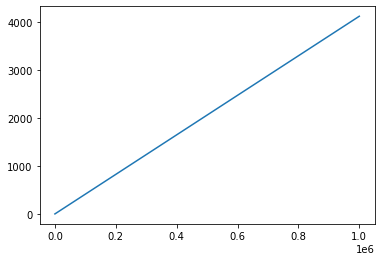

In [117]:
# create linspace for x and y that extrapolates out to 1M
xlinT1 = np.linspace(0,1000000, 1000)
ylinT1 = slopeT1*xlinT1+intT1

plt.plot(xlinT1,ylinT1)

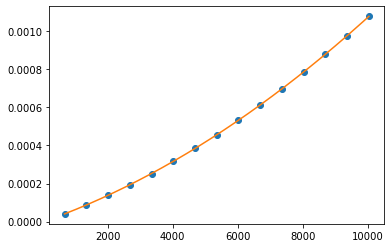

[ 4.70611942e-12  6.04787411e-08 -2.36872872e-06]


In [222]:
# fit a polynomial to prediction time
bt_n2 = []
for i in range(len(bt_n)):
    bt_n2.append(bt_n[i][0])
bt_n2 = np.asarray(bt_n2)

bt_predict_avg2 = []
for i in range(len(bt_predict_avg)):
    bt_predict_avg2.append(bt_predict_avg[i][0])
bt_predict_avg2 = np.asarray(bt_predict_avg2)

p = np.poly1d(np.polyfit(bt_n2,bt_predict_avg2, 2))
t = np.linspace(bt_n2[0], bt_n2[-1], 200)

plt.plot(bt_n2, bt_predict_avg2, 'o', t, p(t), '-')

plt.show()
print(p.c)

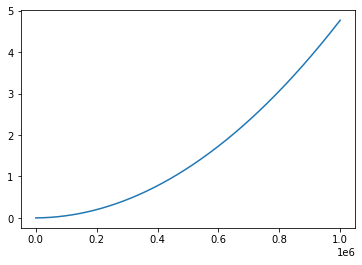

In [234]:
# create linspace for x and y that extrapolates out to 1M
xlinP1 = np.linspace(0,1000000, 1000)
ylinP1 = p(xlinP1)

plt.plot(xlinP1,ylinP1)

In [194]:
# RF timing data from Fig 5 ipynb

bt_T_avg_RF = [4.30506594,  5.84119776,  6.89116531, 11.83606912, 12.74026047, 13.3211622 , 15.17448075, 16.9684286 , 17.7938799 , 18.83544496, 20.13752745, 20.9978307 , 21.65688028, 22.60054992, 23.54835173]
bt_P_avg_RF = [0.00106104, 0.00104266, 0.0010465 , 0.00105338, 0.0010546 , 0.00104912, 0.00105644, 0.00106331, 0.0010779 , 0.00107411, 0.00105925, 0.00105852, 0.00105559, 0.00105226, 0.00104423]

slope_T_RF = 0.002037
int_T_RF = 4.607758

slope_P_RF = 0.00000000
int_P_RF = 0.00105398

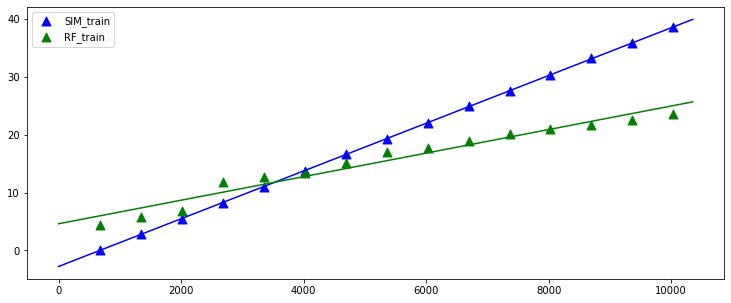

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5,5))

# plot the similarity training time
plt.scatter(bt_n,bt_train_avg, color="blue", marker="^", label="SIM_train", s=80)
# plot the random forest training time
plt.scatter(bt_n,bt_T_avg_RF, color="green", marker="^", label="RF_train", s=80)
plt.legend()

# create linspace for x and y that extrapolates out to 1M
xlinP1 = np.linspace(0,10350, 100)
linT1_SIM = slopeT1*xlinP1+intT1
linP1_SIM = p(xlinP1)
linT1_RF = slope_T_RF*xlinP1+int_T_RF
linP1_RF = slope_P_RF*xlinP1+int_P_RF
# plot the similarity training time
plt.plot(xlinP1,linT1_SIM, color="blue",label="SIM_train_projection")
# plot the random forest training time
plt.plot(xlinP1,linT1_RF, color="green",label="RF_train_projection")

plt.savefig("results/FigS6_sim_v_RF_time_train.svg")
plt.savefig("results/FigS6_sim_v_RF_time_train.png")

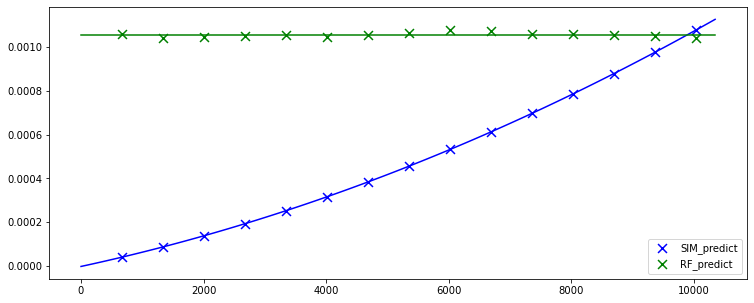

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5,5))

# plot the similarity prediction time
plt.scatter(bt_n,bt_predict_avg, color="blue", marker="x", label="SIM_predict", s=80)
# plot the random forest prediction time
plt.scatter(bt_n,bt_P_avg_RF, color="green", marker="x", label="RF_predict", s=80)
plt.legend()

# create linspace for x and y that extrapolates out to 1M
xlinP1 = np.linspace(0,10350, 100)
linT1_SIM = slopeT1*xlinP1+intT1
linP1_SIM = p(xlinP1)
linT1_RF = slope_T_RF*xlinP1+int_T_RF
linP1_RF = slope_P_RF*xlinP1+int_P_RF
# plot the similarity training time
plt.plot(xlinP1,linP1_SIM, color="blue",label="SIM_train_projection")
# plot the random forest training time
plt.plot(xlinP1,linP1_RF, color="green",label="RF_train_projection")

plt.savefig("results/FigS6_sim_v_RF_time_predict.svg")
plt.savefig("results/FigS6_sim_v_RF_time_predict.png")

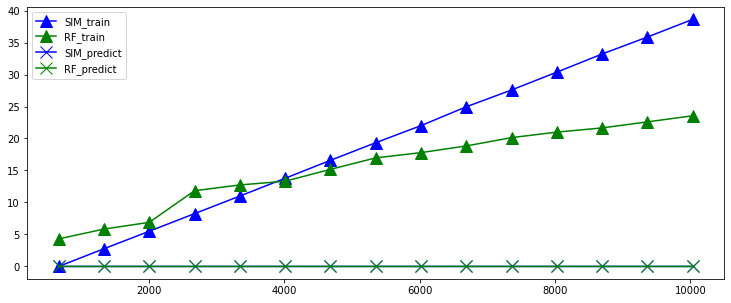

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5,5))

# plot the similarity training time
plt.plot(bt_n,bt_train_avg, color="blue", marker="^", label="SIM_train", markersize=12)
# plot the random forest training time
plt.plot(bt_n,bt_T_avg_RF, color="green", marker="^", label="RF_train", markersize=12)

# plot the similarity prediction time
plt.plot(bt_n,bt_predict_avg, color="blue", marker="x", label="SIM_predict", markersize=12)
# plot the random forest prediction time
plt.plot(bt_n,bt_P_avg_RF, color="green", marker="x", label="RF_predict", markersize=12)

plt.legend()

plt.savefig("results/FigS6_sim_v_RF_time_all.svg")
plt.savefig("results/FigS6_sim_v_RF_time_all.png")

In [8]:
# create linspace for x and y that extrapolates out to 1M
xlinP1 = np.linspace(0,1000000, 1000)
linT1_SIM = slopeT1*xlinP1+intT1
linP1_SIM = p(xlinP1)
linT1_RF = slope_T_RF*xlinP1+int_T_RF
linP1_RF = slope_P_RF*xlinP1+int_P_RF


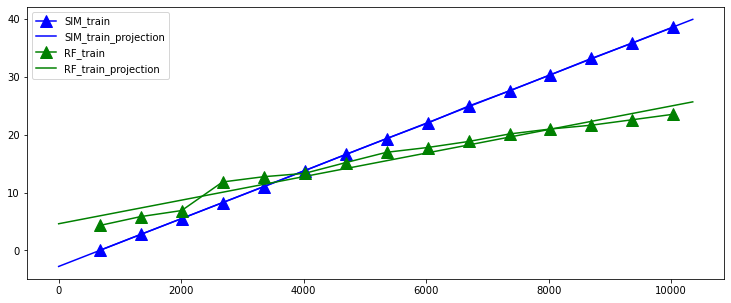

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5,5))

# plot the similarity training time
plt.plot(bt_n,bt_train_avg, color="blue", marker="^", label="SIM_train", markersize=12)
plt.plot(xlinP1,linT1_SIM, color="blue",label="SIM_train_projection")
# plot the random forest training time
plt.plot(bt_n,bt_T_avg_RF, color="green", marker="^", label="RF_train", markersize=12)
plt.plot(xlinP1,linT1_RF, color="green",label="RF_train_projection")

plt.legend()
plt.savefig("results/FigS6_sim_v_RF_time_train_to_1M.svg")
plt.savefig("results/FigS6_sim_v_RF_time_train_to_1M.png")

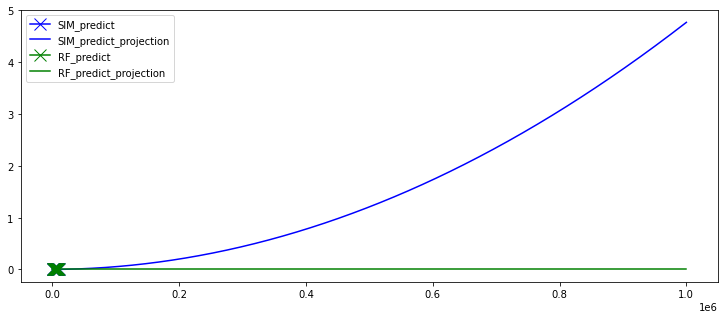

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5,5))

# plot the similarity training time
plt.plot(bt_n,bt_predict_avg, color="blue", marker="x", label="SIM_predict", markersize=12)
plt.plot(xlinP1,linP1_SIM, color="blue",label="SIM_predict_projection")
# plot the random forest training time
plt.plot(bt_n,bt_P_avg_RF, color="green", marker="x", label="RF_predict", markersize=12)
plt.plot(xlinP1,linP1_RF, color="green",label="RF_predict_projection")

plt.legend()
plt.savefig("results/FigS6_sim_v_RF_time_predict_to_1M.svg")
plt.savefig("results/FigS6_sim_v_RF_time_predict_to_1M.png")

In [244]:
# save kernel state
# note that all csv_writer functions are commented out, since they cannot be pickled
import dill
dill.dump_session('item6_updated.db')

In [4]:
## load kernel state
## rerun imports cells 1, 2, and 3 as well
#import dill
#dill.load_session('item6_updated.db')